# INSTALLING ALL LIBRARIES

In [10]:
# computing
import numpy as np
import pandas as pd
import time
from rembg import remove

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import random

# feature extraction
import cv2
from skimage.feature import graycomatrix, graycoprops
from skimage import img_as_ubyte

# modelling
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# evaluation
from sklearn.metrics import accuracy_score

# load/save file
import os
import pickle

## Pickle

In [11]:
def load_file_pickle(filename):
    file_pickle = pickle.load(open(filename, 'rb'))
    return file_pickle

def save_file_pickle(data, filename):
    pickle.dump(data, open(filename, 'wb'))

In [12]:
SVM_WG_FILE_PICKLE = "svm_with_glcm_reduced_model.pkl"
SVM_WOG_FILE_PICKLE = "svm_without_glcm_reduced_model.pkl"
SVM_WG_NOBG_FILE_PICKLE = "svm_with_glcm_nobg_reduced_model.pkl"
SVM_WOG_NOBG_FILE_PICKLE = "svm_without_glcm_nobg_reduced_model.pkl"
SVM_WOG_SCALER_FILE_PICKLE = "svm_without_glcm_reduced_scaler.pkl"
SVM_WOG_NOBG_SCALER_FILE_PICKLE = "svm_without_glcm_nobg_reduced_scaler.pkl"
SVM_WGP_FILE_PICKLE = "svm_with_glcm_plt_reduced_model.pkl" # power law gamma transformation

# Loading Image

In [13]:
# !rembg p -m u2net dataset/train_nobg/freshapples dataset/train_nobg/freshapples_nobg

In [14]:
# !rembg p -m u2net dataset/train_nobg/rottenapples dataset/train_nobg/rottenapples_nobg

In [15]:
# !rembg p -m u2net dataset/test_nobg/freshapples dataset/test_nobg/freshapples_nobg

In [16]:
# !rembg p -m u2net dataset/test_nobg/rottenapples dataset/test_nobg/rottenapples_nobg

In [17]:
# loading image function
def import_image(file) :
    image = cv2.imread(file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = resizing(image, 300)
    return image

def label_image(character, length) :
    array = np.full(length, character)
    return array

def import_data(character, path) :
    file_path = os.listdir(path)
    images = np.array([import_image(path + '/' + file) for file in file_path])
    label = label_image(character, len(file_path))
    
    return images, label

def resizing(image, size):
    image = cv2.resize(image, (size, size), interpolation = cv2.INTER_AREA)
    return image

In [18]:
labels = ('freshapples','rottenapples')

raw_X_train = np.empty((0, 300, 300, 3), np.uint8)
raw_Y_train = np.empty((0))

raw_X_test = np.empty((0, 300, 300, 3), np.uint8)
raw_Y_test = np.empty((0))

# folder_path = "../dataset/train/" # for local used
# folder_path_train = "drive/MyDrive/Colab Notebooks/dataset/train/" # for drive used
# folder_path_test = "drive/MyDrive/Colab Notebooks/dataset/test/"

folder_path_train = "dataset/train_nobg_reduced/" # for drive used
folder_path_test = "dataset/test_nobg/"

for label in labels:
    # for train
    dataset_path_train = folder_path_train + label

    temp_X_train, temp_y_train = import_data(label, dataset_path_train)

    print("Size of train ", label, ":", temp_X_train.shape[0])
    
    raw_X_train = np.append(raw_X_train, temp_X_train, axis=0)
    raw_Y_train = np.append(raw_Y_train, temp_y_train, axis=0)

    # for test
    dataset_path_test = folder_path_test + label

    temp_X_test, temp_y_test = import_data(label, dataset_path_test)

    print("Size of test", label, ":", temp_X_test.shape[0])
    
    raw_X_test = np.append(raw_X_test, temp_X_test, axis=0)
    raw_Y_test = np.append(raw_Y_test, temp_y_test, axis=0)

print("Size of raw Test : ", raw_X_test.shape[0])
print("Size of raw Train : ", raw_X_train.shape[0])

Size of train  freshapples : 1693
Size of test freshapples : 395
Size of train  rottenapples : 1693
Size of test rottenapples : 601
Size of raw Test :  996
Size of raw Train :  3386


### Showing some images

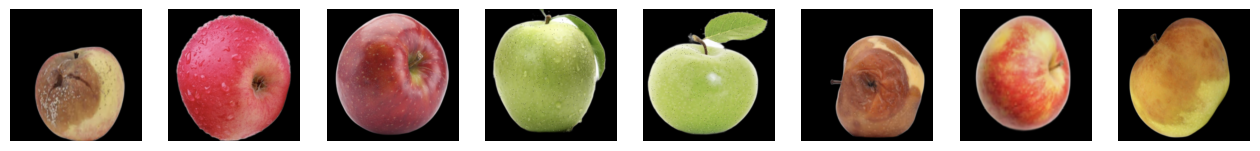

In [19]:
np.random.seed(42) #42 ascii nya bintang

fig = plt.figure(figsize=(16, 4))
columns = 8
rows = 1

for i in range(1, columns*rows + 1):
    img = np.array(raw_X_train[np.random.randint(0, raw_X_train.shape[0]), :])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis('off')

plt.show()

### Showing Image RGB

Text(0.5, 0.98, 'Original & RGB image channels')

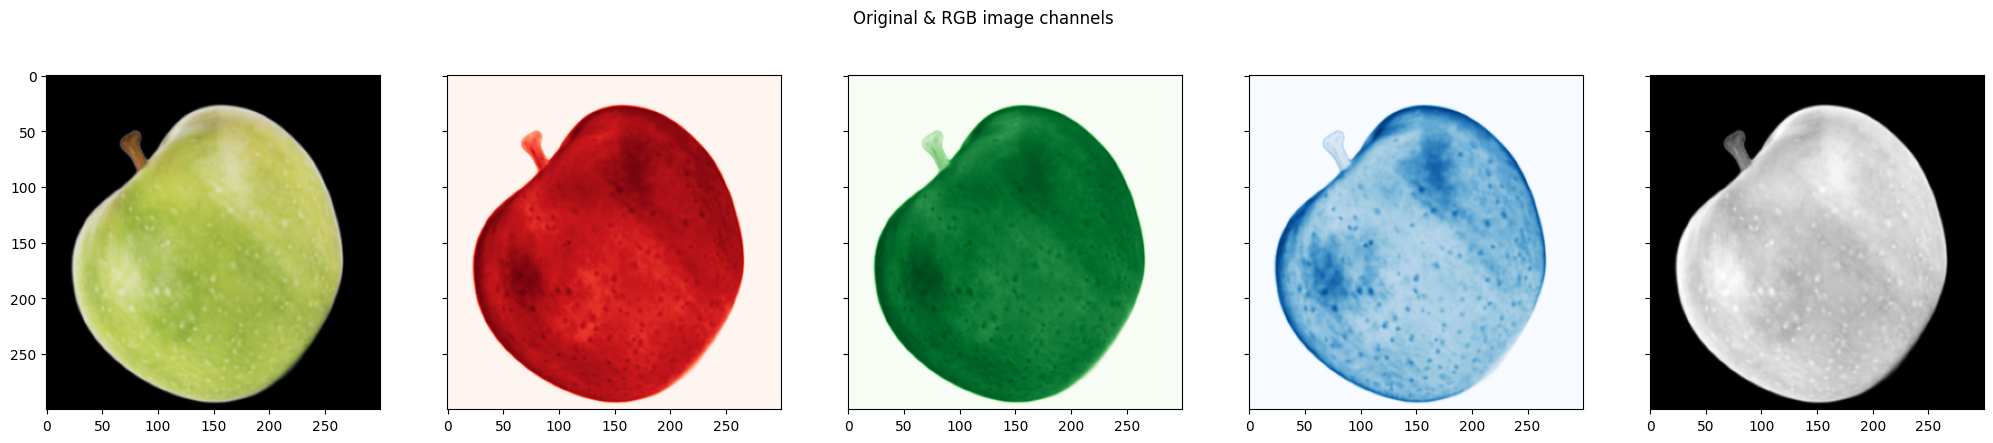

In [20]:
fig, (im1, im2, im3, im4, im5) = plt.subplots(1, 5, sharey=True)
fig.set_figwidth(25) 

img = np.array(raw_X_train[np.random.randint(0, raw_X_train.shape[0]), :])
img_gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

im1.imshow(img)  #Original image
im2.imshow(img[:, : , 0], cmap='Reds') #Red
im3.imshow(img[:, : , 1], cmap='Greens') #Green
im4.imshow(img[:, : , 2], cmap='Blues') #Blue
im5.imshow(img_gray, cmap='gray')
fig.suptitle('Original & RGB image channels')

Text(0.5, 0.98, 'Grayscale image')

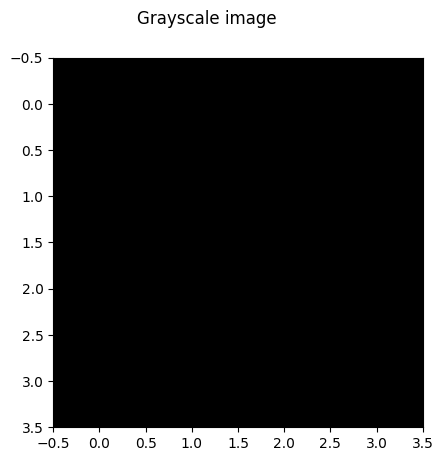

In [21]:
fig, im1 = plt.subplots(1, 1, sharey=True)
fig.set_figwidth(25)
im1.imshow(img_gray[85:89, 54:58], cmap='gray')
fig.suptitle('Grayscale image') 

### Showing Histogram

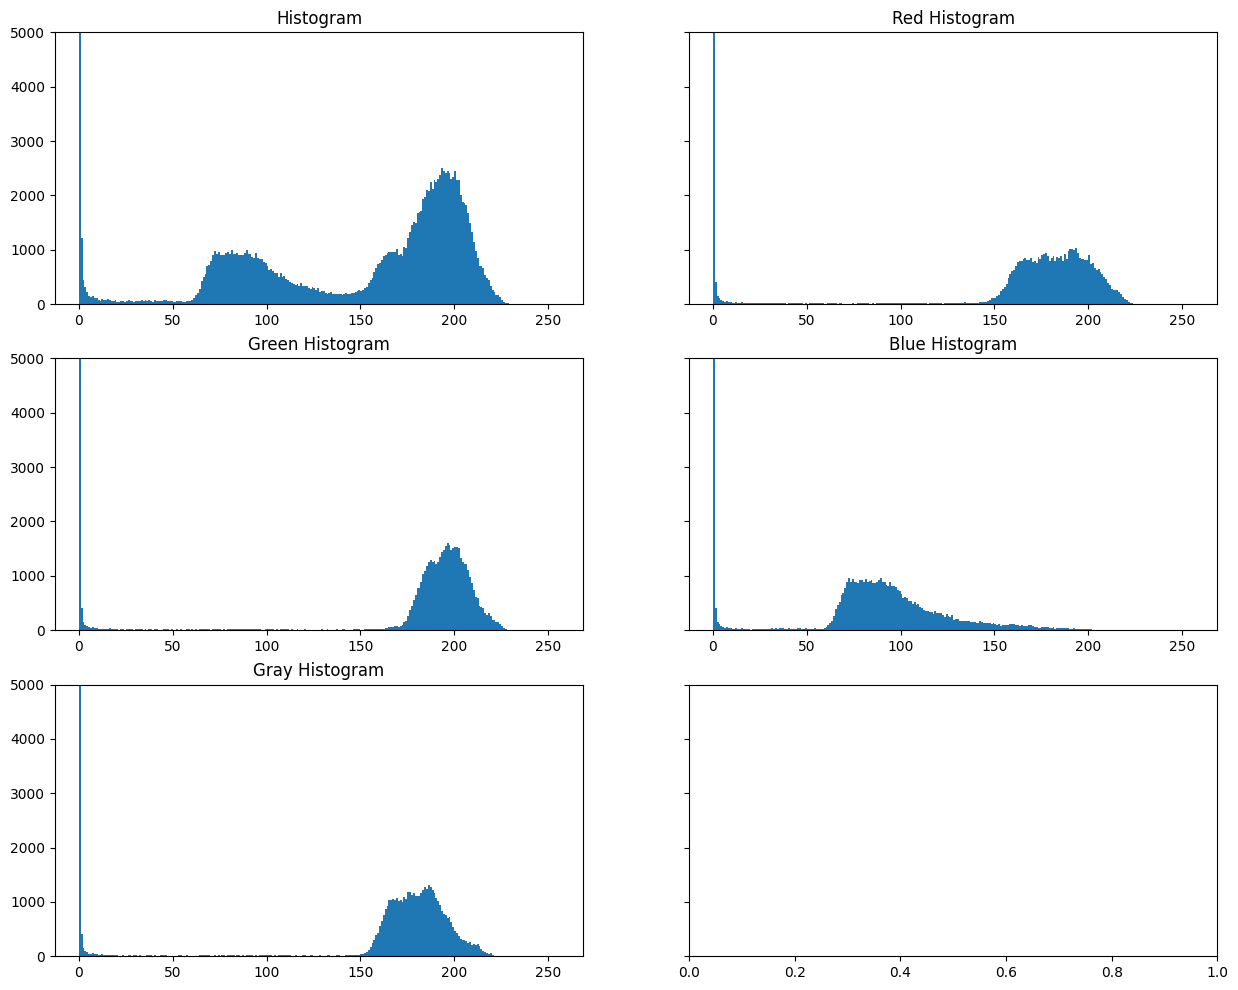

In [22]:
### Checking Histogram (normal color, RGB, grayscale) for knowing contrast and brightness
fig, ((im1, im2), (im3, im4), (im5, im6)) = plt.subplots(nrows=3, ncols=2, sharey=True)
fig.set_figheight(12)
fig.set_figwidth(15)

# show the plotting graph of an image
im1.hist(img.ravel(),256,[0,256], label='RGB') # ravel is for flattening array from 2d to 1d array
im1.set_ylim(0,5000) # limit height of histogram
im1.set_title('Histogram')
im2.hist(img[:,:,0].ravel(),256,[0,256], label='R')
im2.set_title('Red Histogram')
im3.hist(img[:,:,1].ravel(),256,[0,256], label='G')
im3.set_title('Green Histogram')
im4.hist(img[:,:,2].ravel(),256,[0,256], label='B')
im4.set_title('Blue Histogram')
im5.hist(img_gray.ravel(),256,[0,256], label='Gray')
im5.set_title('Gray Histogram')
plt.show()

# Feature Extaction (GLCM)
preprocessing:
- resizing to 300x300
- grayscaling

augmentation(from dataset):
- rotate 15, 45, 60, 75
- salt and pepper
- translation
- vertical flip

In [23]:
# glcm properties
def contrast_feature(matrix_coocurrence):
	contrast = graycoprops(matrix_coocurrence, 'contrast')
	return contrast

def dissimilarity_feature(matrix_coocurrence):
	dissimilarity = graycoprops(matrix_coocurrence, 'dissimilarity')	
	return dissimilarity

def homogeneity_feature(matrix_coocurrence):
	homogeneity = graycoprops(matrix_coocurrence, 'homogeneity')
	return homogeneity

def energy_feature(matrix_coocurrence):
	energy = graycoprops(matrix_coocurrence, 'energy')
	return energy

def correlation_feature(matrix_coocurrence):
	correlation = graycoprops(matrix_coocurrence, 'correlation')
	return correlation

def asm_feature(matrix_coocurrence):
	asm = graycoprops(matrix_coocurrence, 'ASM')
	return asm

def gray_convertion(rgb_img):
	return cv2.cvtColor(rgb_img,cv2.COLOR_RGB2GRAY)

def glcm_extraction(img):
	glcm_feature = np.empty((0, 16), np.uint8)

	for i in range(img.shape[0]):
		img_gray = gray_convertion(img[i])
		image = img_as_ubyte(img_gray) # 69.54% (16-bit), img as ubyte to convert image with value 0-255

		bins = np.array([0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192, 208, 224, 240, 255]) #16-bit = 69.54%
		inds = np.digitize(image, bins) # buat nyari masing2 nilai dari image ada di index berapa kalau di array bins alias matriks quantization (pake indo biar ga ribet wkwk)

		max_value = inds.max()+1 # max value = 256
		matrix_coocurrence = graycomatrix(inds, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=max_value, normed=False, symmetric=False) # matriks cooccurrence
		
		img_energy = energy_feature(matrix_coocurrence)
		img_correlation = correlation_feature(matrix_coocurrence)
		img_contrast = contrast_feature(matrix_coocurrence)
		img_homogenity = homogeneity_feature(matrix_coocurrence)

		temp_glcm_feature = np.empty(0)

		temp_glcm_feature = np.append(img_energy, img_correlation)
		temp_glcm_feature = np.append(temp_glcm_feature, img_contrast)
		temp_glcm_feature = np.append(temp_glcm_feature, img_homogenity)

		glcm_feature = np.append(glcm_feature, [temp_glcm_feature], axis=0)
	
	return glcm_feature
	
	# bins = np.array([0, 32, 64, 96, 128, 160, 192, 224, 255]) #8-bit = 66.9%
	# bins = np.array([0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128, 136, 144, 152, 160, 168, 176, 184, 192, 200, 208, 216, 224, 232, 240, 248, 255]) #32-bit = 69.54%
	
	# without dissimilarity (16-bit) = 69.54%
	# with dissimilarity (16-bit) = 68.94%
	
	# img_dissimilarity = dissimilarity_feature(matrix_coocurrence)
	# img_asm = asm_feature(matrix_coocurrence)
	# temp_glcm_feature = np.append(temp_glcm_feature, img_dissimilarity)
	# temp_glcm_feature = np.append(temp_glcm_feature, img_asm)

### Feature Testing

In [24]:
# source : https://github.com/renbooo/Gray-Level-Cooccurrence-Matrix/blob/master/glcm_fix.py
image = img_as_ubyte(img_gray)

bins = np.array([0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192, 208, 224, 240, 255]) #16-bit
inds = np.digitize(image, bins)

max_value = inds.max()+1
matrix_coocurrence = graycomatrix(inds, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=max_value, normed=False, symmetric=False)

print(energy_feature(matrix_coocurrence))
print(correlation_feature(matrix_coocurrence))
print(contrast_feature(matrix_coocurrence))
print(homogeneity_feature(matrix_coocurrence))
print(dissimilarity_feature(matrix_coocurrence))
print(asm_feature(matrix_coocurrence))

[[0.52253007 0.51718186 0.52407796 0.51604927]]
[[0.9946329  0.9918731  0.99528358 0.99029134]]
[[0.31393534 0.47516247 0.27587514 0.56764466]]
[[0.94859921 0.93894249 0.95311585 0.93867777]]
[[0.13219621 0.16664243 0.11913043 0.17377882]]
[[0.27303768 0.26747708 0.27465771 0.26630685]]


### Feature Extraction

In [25]:
# ekstraksi data training
glcm_feature = glcm_extraction(raw_X_train)

print(glcm_feature)
glcm_feature.shape
inds.max()+1   

[[0.47846856 0.47383266 0.47982429 ... 0.91414214 0.9347355  0.9130342 ]
 [0.52147153 0.51754673 0.5225569  ... 0.94722602 0.96055409 0.95042878]
 [0.42614156 0.41934774 0.42602841 ... 0.91242325 0.93190095 0.91050587]
 ...
 [0.4643084  0.45875719 0.46553933 ... 0.87058891 0.90586136 0.87038809]
 [0.48598988 0.48132795 0.48749559 ... 0.92906018 0.95151022 0.93021429]
 [0.49013488 0.48434622 0.49269173 ... 0.90348465 0.93351399 0.90496621]]


15

In [26]:
# randomize data training
for i in range(5):
    j = random.randrange(len(glcm_feature))
    print(raw_Y_train[j])
    print(glcm_feature[j])

rottenapples
[0.43624396 0.4299588  0.43715915 0.42974407 0.99303041 0.98842452
 0.99401325 0.9889865  0.33598662 0.55755528 0.28860647 0.53048624
 0.93581533 0.91719982 0.93858581 0.9145976 ]
freshapples
[0.50974371 0.50464076 0.51074262 0.50485352 0.9932237  0.98872186
 0.99404081 0.98885027 0.38238573 0.63657006 0.33627648 0.62932182
 0.92231935 0.90188326 0.92857278 0.90321696]
freshapples
[0.40260589 0.39541871 0.40553535 0.39480319 0.98765753 0.98146252
 0.98980213 0.98017458 0.36151616 0.54223107 0.2987291  0.57990403
 0.91054001 0.88951604 0.92076073 0.88708781]
rottenapples
[0.58542999 0.58176285 0.58640731 0.58186188 0.99294339 0.98828807
 0.99401352 0.98941203 0.32787068 0.54478138 0.27814939 0.49250008
 0.92281654 0.90533527 0.92983524 0.90374926]
freshapples
[0.50168581 0.49560554 0.50096182 0.49521113 0.99126317 0.98571239
 0.99107186 0.98563823 0.429699   0.70245299 0.43910814 0.70609948
 0.94799112 0.93067402 0.9432158  0.92951293]


# Modelling (SVM+GLCM)

In [27]:
# Just load model without re-training if you want
# svm_wg = load_file_pickle(SVM_WG_NOBG_FILE_PICKLE)

In [28]:
start_svm_wg = time.time()
# create parameter tuning
num_feature = glcm_feature.shape[1]
_var = glcm_feature.var()
_scale = round(1 / (num_feature * _var), 5) # 5 point accuracy
_dist = round(_scale * 10 / 100, 5)
_scale_1 = round(_scale - (2 * _dist), 5)
_scale_2 = round(_scale - _dist, 5)
_scale_3 = round(_scale + _dist, 5)
_scale_4 = round(_scale + (2 * _dist), 5)

_gamma = [_scale_1, _scale_2, _scale, _scale_3, _scale_4]
_c = [1, 3, 6, 10, 15]

print(_scale)
print(_dist)
print(_gamma)
print(_var)

0.88361
0.08836
[0.70689, 0.79525, 0.88361, 0.97197, 1.06033]
0.07073267174372516


In [29]:
svm_wg_params = {
    'C': _c,
    'gamma': _gamma
}
# cv = cross validation (5 C & 5 Gamma = 125 cv), setiap kombinasi c & gamma diuji 5x
svm_wg = GridSearchCV(estimator=SVC(kernel='rbf', probability=True), param_grid=svm_wg_params, cv=5, verbose=3)

In [30]:
svm_wg.fit(glcm_feature,raw_Y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[CV 1/5] END ................C=1, gamma=0.70689;, score=0.674 total time=   1.8s
[CV 2/5] END ................C=1, gamma=0.70689;, score=0.682 total time=   1.8s
[CV 3/5] END ................C=1, gamma=0.70689;, score=0.687 total time=   1.8s
[CV 4/5] END ................C=1, gamma=0.70689;, score=0.678 total time=   1.8s
[CV 5/5] END ................C=1, gamma=0.70689;, score=0.688 total time=   1.8s
[CV 1/5] END ................C=1, gamma=0.79525;, score=0.683 total time=   1.8s
[CV 2/5] END ................C=1, gamma=0.79525;, score=0.678 total time=   1.8s
[CV 3/5] END ................C=1, gamma=0.79525;, score=0.681 total time=   1.8s
[CV 4/5] END ................C=1, gamma=0.79525;, score=0.682 total time=   1.8s
[CV 5/5] END ................C=1, gamma=0.79525;, score=0.684 total time=   1.8s
[CV 1/5] END ................C=1, gamma=0.88361;, score=0.684 total time=   1.8s
[CV 2/5] END ................C=1, gamma=0.88361;, score=0.679 total time=   1.8s
[CV 3/5] END ...............

GridSearchCV(cv=5, estimator=SVC(probability=True),
             param_grid={'C': [1, 3, 6, 10, 15],
                         'gamma': [0.70689, 0.79525, 0.88361, 0.97197,
                                   1.06033]},
             verbose=3)

In [31]:
end_svm_wg = time.time()

In [32]:
time_elapsed_wg = end_svm_wg-start_svm_wg
print("Best Model:", svm_wg.best_estimator_)
print("Best CV Score:", svm_wg.best_score_)
print("Total Elapsed Time:", time_elapsed_wg)

Best Model: SVC(C=15, gamma=1.06033, probability=True)
Best CV Score: 0.7291747820289931
Total Elapsed Time: 216.77788376808167


In [33]:
cv_results_df = pd.DataFrame(svm_wg.cv_results_)
cv_results_df = cv_results_df.sort_values(by=['rank_test_score'])
cv_results_df = (
    cv_results_df
    .set_index(cv_results_df["params"].apply(
        lambda x: "_".join(str(val) for val in x.values()))
    )
    .rename_axis('kernel')
)
cv_results_df[
    ['params', 'rank_test_score', 'mean_test_score', 'std_test_score']
]

,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
15_1.06033,"{'C': 15, 'gamma': 1.06033}",1,0.729175,0.007476
15_0.97197,"{'C': 15, 'gamma': 0.97197}",2,0.728585,0.006281
15_0.79525,"{'C': 15, 'gamma': 0.79525}",3,0.728290,0.007028
15_0.70689,"{'C': 15, 'gamma': 0.70689}",4,0.728290,0.005804
15_0.88361,"{'C': 15, 'gamma': 0.88361}",5,0.727109,0.007544
10_1.06033,"{'C': 10, 'gamma': 1.06033}",6,0.725631,0.007674
10_0.97197,"{'C': 10, 'gamma': 0.97197}",7,0.725042,0.006460
10_0.88361,"{'C': 10, 'gamma': 0.88361}",8,0.722975,0.006793
10_0.79525,"{'C': 10, 'gamma': 0.79525}",9,0.720615,0.007188


### Saving Model

In [34]:
save_file_pickle(svm_wg, SVM_WG_NOBG_FILE_PICKLE)

# Predicting (SVM+GLCM)
C=15, gamma=0.82092

### Feature Extraction

In [35]:
glcm_feature_predict = glcm_extraction(raw_X_test)

print(glcm_feature_predict)
glcm_feature_predict.shape
inds.max()+1   

[[0.43688026 0.43012493 0.43839581 ... 0.91230093 0.93668074 0.91262626]
 [0.55565825 0.55124378 0.55570555 ... 0.93904551 0.95226299 0.93635661]
 [0.46568347 0.45793521 0.46328447 ... 0.92819918 0.94320063 0.93355593]
 ...
 [0.39128134 0.38497684 0.39613788 ... 0.84151934 0.89283762 0.84000369]
 [0.42500632 0.41968699 0.42599883 ... 0.90949636 0.93127085 0.90295635]
 [0.37930806 0.36954998 0.38049645 ... 0.86247814 0.89705825 0.86496353]]


15

### Predicting

#### Testing

In [36]:
test = svm_wg.predict_proba(np.reshape(glcm_feature_predict[0], (1,-1)))
test

array([[0.57318118, 0.42681882]])

In [37]:
glcm_feature_predict[0]

array([0.43688026, 0.43012493, 0.43839581, 0.43060094, 0.98826558,
       0.98189284, 0.99044284, 0.98177864, 0.34272018, 0.52853995,
       0.27913043, 0.53187325, 0.93141109, 0.91230093, 0.93668074,
       0.91262626])

In [38]:
test_acc = round(test.max() * 100, 2)
test_acc

57.32

#### Predicting Accuracy (SVM+GLCM)

In [39]:
Y_predict_wg = svm_wg.predict(glcm_feature_predict)

In [40]:
acc_wg = accuracy_score(raw_Y_test, Y_predict_wg)
print("Accuracy score:", acc_wg)

Accuracy score: 0.7309236947791165


# Modelling (SVM)

In [41]:
# Just load model without re-training in case you need fast
# svm_wog = load_file_pickle(SVM_WOG_NOBG_FILE_PICKLE)

### Resizing & Flattening

In [42]:
size = 32
img_resize_flatten = np.empty((0,size*size*3), np.uint8)

print(raw_X_train[0].shape)
for i in range(raw_X_train.shape[0]):
    # image = img_as_ubyte(raw_X_test[i])
    img_resized = resizing(raw_X_train[i],32)
    img_flat = img_resized.ravel()
    img_resize_flatten = np.append(img_resize_flatten, [img_flat], axis=0)

print(img_resize_flatten.shape)

(300, 300, 3)
(3386, 3072)


In [43]:
print(img_resize_flatten)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


### MinMaxScaler Normalization

In [44]:
# scaler = load_file_pickle(SVM_WOG_NOBG_SCALER_FILE_PICKLE)

In [45]:
scaler = MinMaxScaler()
scaler.fit(img_resize_flatten)
img_resize_flatten_scale = scaler.transform(img_resize_flatten)

In [46]:
save_file_pickle(scaler, SVM_WOG_NOBG_SCALER_FILE_PICKLE)

### Modelling

In [47]:
start_svm_wog = time.time()
num_feature = img_resize_flatten.shape[1]
_var = img_resize_flatten.var()
_scale = round(1 / (num_feature * _var), 5) # 5 point accuracy
_dist = round(_scale * 10 / 100, 5)
_scale_1 = round(_scale - (2 * _dist), 5)
_scale_2 = round(_scale - _dist, 5)
_scale_3 = round(_scale + _dist, 5)
_scale_4 = round(_scale + (2 * _dist), 5)

_gamma = [_scale_1, _scale_2, _scale, _scale_3, _scale_4]
# _gamma = [_scale]
_c = [1, 3, 6, 10, 15]

print(_scale)
print(_dist)
print(_gamma)
print(_var)
print(num_feature)

0.0
0.0
[0.0, 0.0, 0.0, 0.0, 0.0]
5948.255540261489
3072


In [48]:
svm_wog_params = {
    'C': _c,
}
# cv = cross validation (5 C & 5 Gamma = 125 cv), setiap kombinasi c & gamma diuji 5x
svm_wog = GridSearchCV(estimator=SVC(kernel='rbf', probability=True, gamma='auto'), param_grid=svm_wog_params, cv=2, verbose=3)
# cv / cross validation turned off cause it takes long time each itteration (1.6 min/itteration)

In [49]:
svm_wog.fit(img_resize_flatten,raw_Y_train)

Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV 1/2] END ...............................C=1;, score=0.500 total time=  29.3s
[CV 2/2] END ...............................C=1;, score=0.500 total time=  29.0s
[CV 1/2] END ...............................C=3;, score=0.500 total time=  28.2s
[CV 2/2] END ...............................C=3;, score=0.500 total time=  28.9s
[CV 1/2] END ...............................C=6;, score=0.500 total time=  29.9s
[CV 2/2] END ...............................C=6;, score=0.500 total time=  30.1s
[CV 1/2] END ..............................C=10;, score=0.500 total time=  29.1s
[CV 2/2] END ..............................C=10;, score=0.500 total time=  28.2s
[CV 1/2] END ..............................C=15;, score=0.500 total time=  28.3s
[CV 2/2] END ..............................C=15;, score=0.500 total time=  28.3s


GridSearchCV(cv=2, estimator=SVC(gamma='auto', probability=True),
             param_grid={'C': [1, 3, 6, 10, 15]}, verbose=3)

In [50]:
end_svm_wog = time.time()

In [51]:
time_elapsed_wog = end_svm_wog-start_svm_wog
print("Best Model:", svm_wog.best_estimator_)
print("Best CV Score:", svm_wog.best_score_)
print("Total Elapsed Time:", time_elapsed_wog)

Best Model: SVC(C=1, gamma='auto', probability=True)
Best CV Score: 0.5
Total Elapsed Time: 374.1709101200104


In [52]:
cv_results_df = pd.DataFrame(svm_wog.cv_results_)
cv_results_df = cv_results_df.sort_values(by=['rank_test_score'])
cv_results_df = (
    cv_results_df
    .set_index(cv_results_df["params"].apply(
        lambda x: "_".join(str(val) for val in x.values()))
    )
    .rename_axis('kernel')
)
cv_results_df[
    ['params', 'rank_test_score', 'mean_test_score', 'std_test_score']
]

,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
1,{'C': 1},1,0.5,0.000295
3,{'C': 3},1,0.5,0.000295
6,{'C': 6},1,0.5,0.000295
10,{'C': 10},1,0.5,0.000295
15,{'C': 15},1,0.5,0.000295


In [53]:
save_file_pickle(svm_wog, SVM_WOG_NOBG_FILE_PICKLE)

# Predicting (SVM)
C=1, gamma=0.00284

In [54]:
size = 32
img_resize_flatten_predict = np.empty((0,size*size*3), np.uint8) # flattening with 3 color (RGB)

print(raw_X_test[0].shape)
for i in range(raw_X_test.shape[0]):
    # image = img_as_ubyte(raw_X_test[i])
    img_resized = resizing(raw_X_test[i],32)
    img_flat = img_resized.ravel()
    img_resize_flatten_predict = np.append(img_resize_flatten_predict, [img_flat], axis=0)

print(img_resize_flatten_predict.shape)

(300, 300, 3)
(996, 3072)


In [55]:
img_resize_flatten_predict[0]

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [56]:
img_resize_flatten_predict_scale = scaler.transform(img_resize_flatten_predict)

In [57]:
Y_predict_wog = svm_wog.predict(img_resize_flatten_predict)

In [58]:
acc_wog = accuracy_score(raw_Y_test, Y_predict_wog)
print("Accuracy score:", acc_wog)

Accuracy score: 0.45180722891566266


### Overfit Test

In [59]:
# train_scores, test_scores = list(), list()
# values = [i for i in range(1, 11)]

# for i in values:
#    train_yhat = svm_wog.predict(img_resize_flatten)
#    train_acc = accuracy_score(raw_Y_train, train_yhat)
#    train_scores.append(train_acc)
#    # evaluate on the test dataset
#    test_yhat = svm_wog.predict(img_resize_flatten_predict)
#    test_acc = accuracy_score(raw_Y_test, test_yhat)
#    test_scores.append(test_acc)

#    print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))

# plt.plot(values, train_scores, '-o', label='Train')
# plt.plot(values, test_scores, '-o', label='Test')
# plt.legend()
# plt.show()

# Compare

In [60]:
compare_df = pd.DataFrame({"Model_SVM": ["Without GLCM", "With GLCM"],
                          "Accuracy": [acc_wog, acc_wg]})

compare_df

,Model_SVM,Accuracy
0,Without GLCM,0.451807
1,With GLCM,0.730924


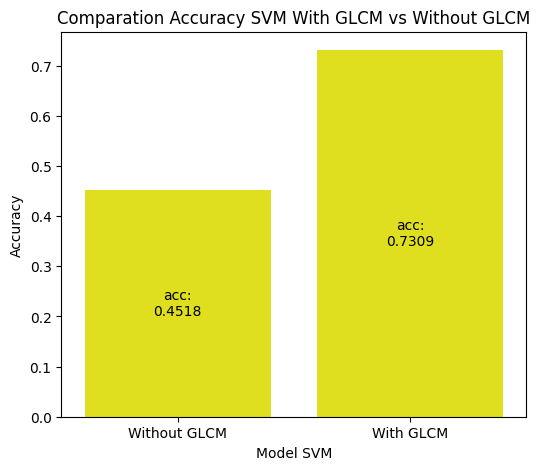

In [61]:
fig, ax = plt.subplots(figsize=(6, 5))

sns.barplot(x = 'Model_SVM',
            y = 'Accuracy',
            data = compare_df,
            ax=ax,
            color='yellow')

ax.bar_label(ax.containers[-1], fmt='acc:\n%.4f', label_type='center')
ax.set(ylabel='Accuracy', xlabel='Model SVM', title="Comparation Accuracy SVM With GLCM vs Without GLCM")

plt.show()

In [62]:
compare_time_df = pd.DataFrame({"Model_SVM": ["Without GLCM", "With GLCM"],
                          "Time Elapsed": [end_svm_wog-start_svm_wog, end_svm_wg-start_svm_wg]})

compare_time_df

,Model_SVM,Time Elapsed
0,Without GLCM,374.170910
1,With GLCM,216.777884


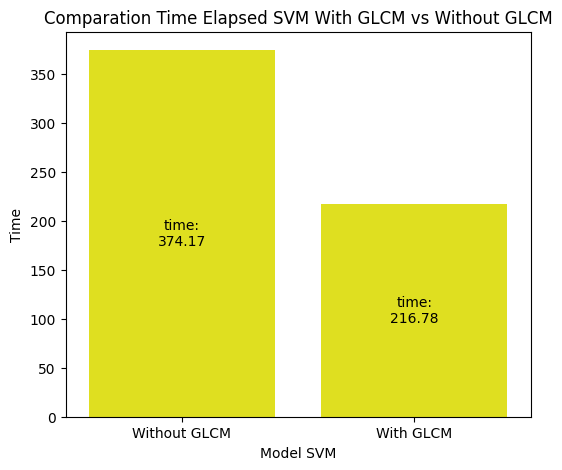

In [63]:
fig, ax = plt.subplots(figsize=(6, 5))

sns.barplot(x = 'Model_SVM',
            y = 'Time Elapsed',
            data = compare_time_df,
            ax=ax,
            color='yellow')

ax.bar_label(ax.containers[-1], fmt='time:\n%.2f', label_type='center')
ax.set(ylabel='Time', xlabel='Model SVM', title="Comparation Time Elapsed SVM With GLCM vs Without GLCM")

plt.show()

In [64]:
print('selisih akurasi : ', (acc_wg-acc_wog)*100)
print('selisih waktu : ', time_elapsed_wog-time_elapsed_wg)

selisih akurasi :  27.91164658634538
selisih waktu :  157.3930263519287
